In [1]:
import xarray as xr
xr.set_options(keep_attrs=True)
import gcsfs
import numpy as np
from xmip.preprocessing import rename_cmip6
from datatree import DataTree
import matplotlib.pyplot as plt
from datatree import map_over_subtree
from datatree import open_datatree

In [6]:
cmip_stores = {
'IPSL-CM6A-LR/historical':  'gs://cmip6/CMIP6/CMIP/IPSL/IPSL-CM6A-LR/historical/r4i1p1f1/Omon/tos/gn/v20180803/',
'MPI-ESM1-2-LR/historical': 'gs://cmip6/CMIP6/CMIP/MPI-M/MPI-ESM1-2-LR/historical/r4i1p1f1/Omon/tos/gn/v20190710/',
'CESM2/historical':         'gs://cmip6/CMIP6/CMIP/NCAR/CESM2/historical/r4i1p1f1/Omon/tos/gn/v20190308/',
'IPSL-CM6A-LR/ssp126':      'gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp126/r4i1p1f1/Omon/tos/gn/v20191121/',
'IPSL-CM6A-LR/ssp585':      'gs://cmip6/CMIP6/ScenarioMIP/IPSL/IPSL-CM6A-LR/ssp585/r4i1p1f1/Omon/tos/gn/v20191122/',
'MPI-ESM1-2-LR/ssp126':     'gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp126/r4i1p1f1/Omon/tos/gn/v20190710/',
'MPI-ESM1-2-LR/ssp585':     'gs://cmip6/CMIP6/ScenarioMIP/MPI-M/MPI-ESM1-2-LR/ssp585/r4i1p1f1/Omon/tos/gn/v20190710/',
'CESM2/ssp126':             'gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp126/r4i1p1f1/Omon/tos/gn/v20200528/',
'CESM2/ssp585':             'gs://cmip6/CMIP6/ScenarioMIP/NCAR/CESM2/ssp585/r4i1p1f1/Omon/tos/gn/v20200528/'
}

datasets = {
    name: rename_cmip6(xr.open_dataset(path, engine="zarr")).load()
    for name, path in cmip_stores.items()
}

In [7]:
dt = DataTree.from_dict(datasets)

for i in dt['/CESM2'].keys():
    dt[f'/CESM2/{i}'] = dt[f'/CESM2/{i}'].assign_coords(time=("time", np.array([np.datetime64(j)
                                                                               for j in
                                                                               dt[f'/CESM2/{i}']['time'].values])))

timeseries = dt.mean(dim=["x", "y"])

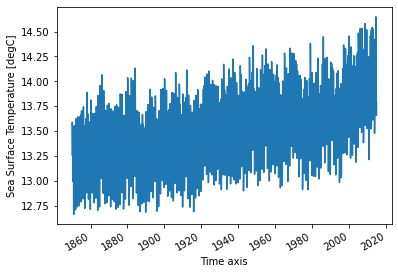

In [8]:
timeseries['/IPSL-CM6A-LR/historical'].ds['tos'].plot()

In [9]:
def mean_over_space(ds):
    return ds.mean(dim=["x", "y"])
_ = dt.map_over_subtree(mean_over_space)

In [10]:
# timeseries.to_zarr('cmip_timeseries')  # or netcdf, with any group structure
roundtrip = open_datatree('cmip_timeseries', engine="zarr")

In [11]:
anomaly = DataTree()
for model_name, model in timeseries.children.items():
    
    # model-specific base period as an xarray.Dataset
    base_period = model["historical"].ds.sel(time=slice('1950','1980')).mean('time')
    
    anomaly[model_name] = model - base_period   # subtree - Dataset

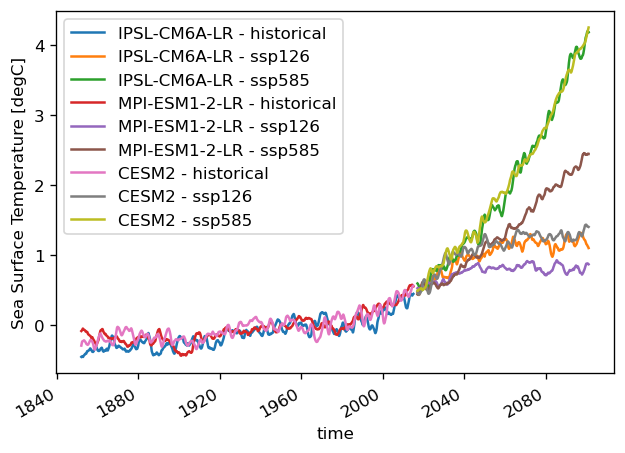

In [12]:
fig, ax = plt.subplots(dpi=120)

@map_over_subtree
def plot_temp(ds, original_ds):
    
    if ds:
        label = f'{original_ds.attrs["source_id"]} - {original_ds.attrs["experiment_id"]}'
        ds['tos'].rolling(time=2*12).mean().plot(ax=ax, label=label)
    return ds
   
plot_temp(anomaly, timeseries)
ax.legend()